In [1]:
# Cell 1: Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV3Large
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import os


In [2]:
# Cell 2: Load dataset with preprocessing and augmentation
dataset_dir = r"C:\Users\saima\OneDrive\Desktop\Garbage-Classification\Week 1\TrashType_Image_Dataset"
image_size = (224, 224)
batch_size = 32
seed = 42

# Data augmentation layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
])

# Load training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [3]:
# Cell 3: Compute class weights and build MobileNetV3 model

# Extract labels for class weight computation
y_train = []
for images, labels in train_ds:
    y_train.extend(labels.numpy())

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Prepare preprocessing and model base
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

base_model = MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze base initially

# Build full model
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [6]:
# Cell 4: Train model with callbacks

# Define callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "mobilenetv3_best_model.keras",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

earlystop_cb = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor='val_accuracy',  # ← changed from val_loss
    mode='max'               # ← maximizes val_accuracy
)


reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb],
    class_weight=class_weights
)


Epoch 1/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 550ms/step - accuracy: 0.9021 - loss: 0.3037 - val_accuracy: 0.8733 - val_loss: 0.3477 - learning_rate: 2.0000e-04
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 541ms/step - accuracy: 0.8923 - loss: 0.3058 - val_accuracy: 0.8772 - val_loss: 0.3451 - learning_rate: 2.0000e-04
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 35s 546ms/step - accuracy: 0.8908 - loss: 0.3300 - val_accuracy: 0.8832 - val_loss: 0.3482 - learning_rate: 2.0000e-04
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 34s 525ms/step - accuracy: 0.8993 - loss: 0.2964 - val_accuracy: 0.8832 - val_loss: 0.3462 - learning_rate: 2.0000e-04
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9106 - loss: 0.2714
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
64/64 ━━━━━━━━━━━━━━━━━━━━ 34s 522ms/step - accuracy: 0.9103 - loss: 0.2720 - val_accuracy: 0.8733 - val_loss: 0.3472 - learning_rate: 2.0000e-04
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 33s 518ms/step - accuracy

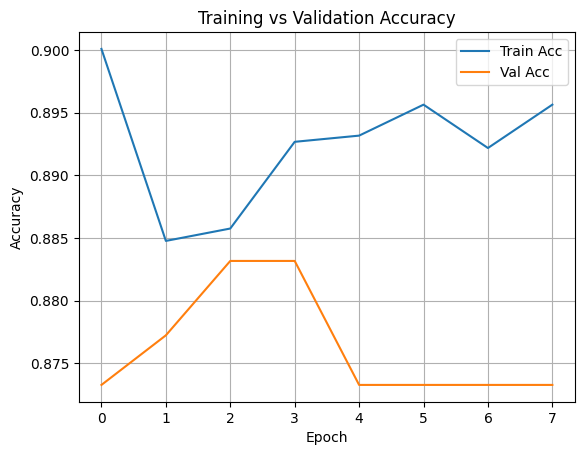

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
Classification Report:
              precision    recall  f1-score   support

   cardboard       0.97      0.84      0.90        69
       glass       0.94      0.89      0.91       102
       metal       0.82      0.97      0.89        88
       paper       0.89      0.94      0.92       123
     plastic       0.94      0.85      0.89        89
       trash       0.79     

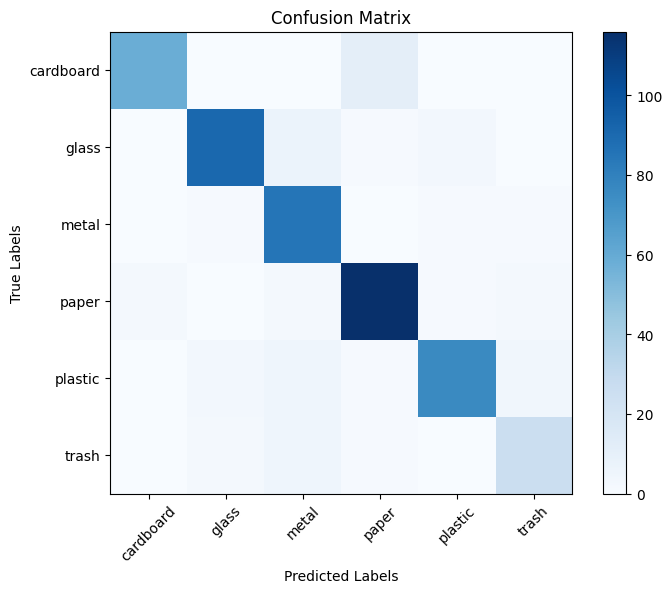

In [10]:
# Cell 5: Evaluate model and visualize results

# Plot training history
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Predict on validation set
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.colorbar()
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.show()


In [8]:
# Cell 6: Fine-tune top layers of MobileNetV3

# Unfreeze the top 30 layers of the base model
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # lower LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb],
    class_weight=class_weights
)


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 56s 655ms/step - accuracy: 0.8309 - loss: 0.4643 - val_accuracy: 0.8832 - val_loss: 0.3378 - learning_rate: 1.0000e-05
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 639ms/step - accuracy: 0.8499 - loss: 0.4230 - val_accuracy: 0.8891 - val_loss: 0.3315 - learning_rate: 1.0000e-05
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 652ms/step - accuracy: 0.8553 - loss: 0.4304 - val_accuracy: 0.8911 - val_loss: 0.3298 - learning_rate: 1.0000e-05
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 663ms/step - accuracy: 0.8666 - loss: 0.3761 - val_accuracy: 0.8950 - val_loss: 0.3279 - learning_rate: 1.0000e-05
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 655ms/step - accuracy: 0.8586 - loss: 0.4060 - val_accuracy: 0.8950 - val_loss: 0.3283 - learning_rate: 1.0000e-05
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 646ms/step - accuracy: 0.8658 - loss: 0.3715 - val_accuracy: 0.8950 - val_loss: 0.3294 - learning_rate: 1.0000e-05
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accu